# Module

In [1]:
from dotenv import load_dotenv
import os

from typing import Annotated, Literal
from typing_extensions import TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from langchain_core.messages import BaseMessage
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

import json
from IPython.display import Image, display

from langchain_core.messages import ToolMessage

# .env 파일 로드
load_dotenv()

True

### Memory checkpointer 생성

In [2]:
memory = MemorySaver()

### State 생성

In [3]:
class State(TypedDict):
    messages : Annotated[list, add_messages]

### Graph 생성

In [4]:
graph_builder = StateGraph(State)

### Tool 및 LLM 생성

In [5]:
tool = TavilySearchResults(max_results=2)
tools = [tool]
llm = ChatOpenAI(model="gpt-4o")
llm_with_tools = llm.bind_tools(tools)

### Node 생성

In [6]:
def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

tool_node = ToolNode(tools=tools)

### Node 및 Edge 연결

In [7]:
# Node 추가
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

# Edge 추가
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("tools", "chatbot")

# conditional Edge 추가
graph_builder.add_conditional_edges("chatbot", tools_condition)

### 컴파일 - Checkpointer 활용

In [8]:
graph = graph_builder.compile(checkpointer=memory)

### 시각화

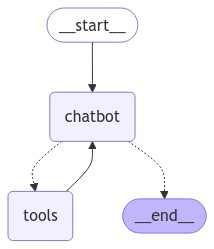

In [9]:
try:
    display(
        Image(
            graph.get_graph().draw_mermaid_png(
                output_file_path="./add_memory_to_chatbot.png"
            )
        )
    )
except Exception:
    pass

### 대화를 위한 config 설정

In [10]:
config = {"configurable": {"thread_id": "1"}}

### Run

In [ ]:
user_input = "Hi there! My name is Rimo."

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Hi there! My name is Rimo.
================================== Ai Message ==================================

Hello Rimo! How can I assist you today?


In [12]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)
for event in events:
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Remember my name?
================================== Ai Message ==================================

Yes, your name is Rimo! How can I assist you further today?


### Config가 바뀐다면?

In [ ]:
user_input = "Remember my name?"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, {"configurable":{"thread_id":"hi"}}, stream_mode="values"
)
for event in events:
    print(event["messages"])#[)-1].pretty_print()

[HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2dbb71bc-8ee5-4108-a158-54e50e6959e7')]
[HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='2dbb71bc-8ee5-4108-a158-54e50e6959e7'), AIMessage(content="I'm sorry, I don't have access to personal data about users unless it has been shared with me in the course of our conversation. I'm designed to respect user privacy and confidentiality.", additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 36, 'prompt_tokens': 83, 'total_tokens': 119, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_12915b46c9', 'finish_reason': 'stop', 'logprobs': None}, id='run-d83a3f77-7c61-4f61-847e-beac8c19ebb5-0', usage_metadata={'i

### 특정 config의 State 상태를 보려면?

In [14]:
snapshot = graph.get_state(config)

In [15]:
snapshot_value = snapshot.values

In [16]:
len(snapshot_value)

2

In [18]:
snapshot_value["messages"]

[HumanMessage(content='Hi there! My name is Rimo.', additional_kwargs={}, response_metadata={}, id='46468d8c-b5b1-4cfe-8511-0c76cd33789d'),
 AIMessage(content='Hello Rimo! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 88, 'total_tokens': 100, 'completion_tokens_details': {'audio_tokens': 0, 'reasoning_tokens': 0, 'accepted_prediction_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_159d8341cc', 'finish_reason': 'stop', 'logprobs': None}, id='run-064efdcc-5fc6-4478-8075-e2169770f365-0', usage_metadata={'input_tokens': 88, 'output_tokens': 12, 'total_tokens': 100, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 HumanMessage(content='Remember my name?', additional_kwargs={}, response_metadata={}, id='3bf901e

### Test

In [10]:
config = {"configurable": {"thread_id": "test"}}

In [17]:
user_input = "please search for me"

# The config is the **second positional argument** to stream() or invoke()!
events = graph.stream(
    {"messages": [("user", user_input)]}, config, stream_mode="values"
)

In [18]:
for event in events:
    print(event["messages"])#[)-1].pretty_print()

[HumanMessage(content='what is 3d segmentations?', additional_kwargs={}, response_metadata={}, id='248127d3-ed50-43cb-b80a-f3b7c58f0945'), AIMessage(content='3D segmentation refers to the process of partitioning a three-dimensional digital image or a 3D model into multiple segments, often to simplify the representation of the image or to make it more meaningful and easier to analyze. This technique is widely used in various fields, such as medical imaging, computer vision, and robotics. \n\nThe main goal of 3D segmentation is to identify and delineate structures within the 3D data. Here are a few details about its application:\n\n1. **Medical Imaging**: In medical imaging, 3D segmentation is crucial for identifying anatomical structures, such as organs, tissues, or tumors, within MRI or CT scans. This helps in diagnosis, treatment planning, and image-guided surgery.\n\n2. **Computer Vision**: In computer vision, 3D segmentation can be used to recognize and classify objects within a sce

In [19]:
snapshot = graph.get_state(config)

In [20]:
snapshot_values = snapshot.values

In [21]:
snapshot_values["messages"]

[HumanMessage(content='what is 3d segmentations?', additional_kwargs={}, response_metadata={}, id='248127d3-ed50-43cb-b80a-f3b7c58f0945'),
 AIMessage(content='3D segmentation refers to the process of partitioning a three-dimensional digital image or a 3D model into multiple segments, often to simplify the representation of the image or to make it more meaningful and easier to analyze. This technique is widely used in various fields, such as medical imaging, computer vision, and robotics. \n\nThe main goal of 3D segmentation is to identify and delineate structures within the 3D data. Here are a few details about its application:\n\n1. **Medical Imaging**: In medical imaging, 3D segmentation is crucial for identifying anatomical structures, such as organs, tissues, or tumors, within MRI or CT scans. This helps in diagnosis, treatment planning, and image-guided surgery.\n\n2. **Computer Vision**: In computer vision, 3D segmentation can be used to recognize and classify objects within a sc